In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#cr_cp = pm.df('cr_cp')
#fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()

,stat_cr_canceled,stat_cr_direct_debit_rejected,stat_cr_direct_debit_sent,stat_cr_money_back,stat_cr_rejected,stat_cr_transaction_declined,stat_fe_cancelled,stat_fe_confirmed,stat_fe_cr_regular,stat_fe_rejected,recovery_status_completed,recovery_status_nice,recovery_status_pending,recovery_status_pending_direct_debit
0,True,False,False,False,False,False,False,False,True,False,False,True,False,False


,stat_cr_canceled,stat_cr_direct_debit_rejected,stat_cr_direct_debit_sent,stat_cr_money_back,stat_cr_rejected,stat_cr_transaction_declined,stat_fe_cancelled,stat_fe_confirmed,stat_fe_cr_regular,stat_fe_rejected,recovery_status_completed,recovery_status_nice,recovery_status_pending,recovery_status_pending_direct_debit
0,30.264076,-0.253724,-0.048075,-1.623853,-0.507274,-0.038703,-0.426237,-0.052437,1.381186,-0.196579,-0.438017,0.537771,-0.257529,-0.033512
1,-0.033042,-0.253724,-0.048075,0.615819,-0.507274,-0.038703,-0.426237,-0.052437,1.381186,-0.196579,-0.438017,0.537771,-0.257529,-0.033512


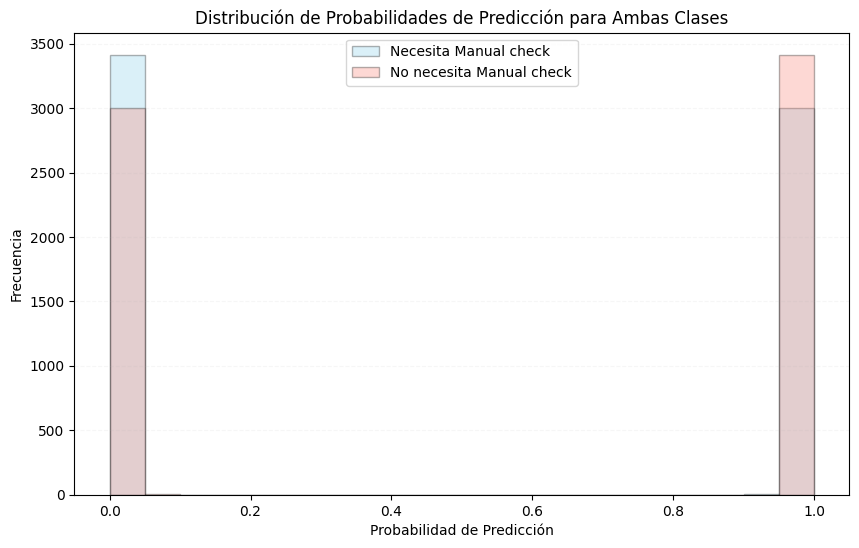

predicciones_probabilidades:
 [[9.99696847e-01 3.03153403e-04]
 [3.34498140e-09 9.99999997e-01]
 [6.12944546e-04 9.99387055e-01]
 [9.99696847e-01 3.03153403e-04]
 [9.54543765e-04 9.99045456e-01]
 [3.74325334e-04 9.99625675e-01]
 [5.09893347e-04 9.99490107e-01]
 [5.09893347e-04 9.99490107e-01]
 [3.74325334e-04 9.99625675e-01]
 [9.54543765e-04 9.99045456e-01]]

Coeficientes del modelo de regresión logística (ordenados por magnitud):
stat_fe_cancelled: 5.4302
stat_cr_rejected: 4.0310
recovery_status_completed: 3.2344
recovery_status_nice: -2.8702
stat_cr_money_back: -2.5754
stat_fe_rejected: 1.8244
stat_cr_direct_debit_rejected: 1.2603
stat_cr_transaction_declined: 0.4992
stat_cr_canceled: 0.3577
recovery_status_pending_direct_debit: 0.1862
stat_fe_confirmed: -0.1668
stat_cr_direct_debit_sent: -0.1294
stat_fe_cr_regular: 0.1101
recovery_status_pending: 0.0101


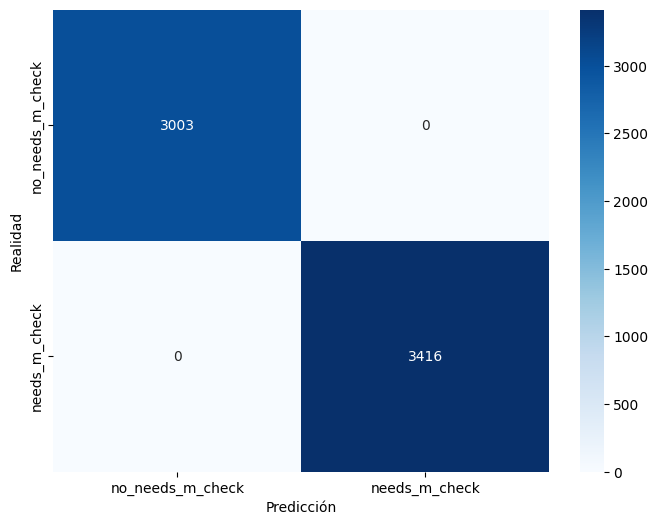

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3003
           1       1.00      1.00      1.00      3416

    accuracy                           1.00      6419
   macro avg       1.00      1.00      1.00      6419
weighted avg       1.00      1.00      1.00      6419



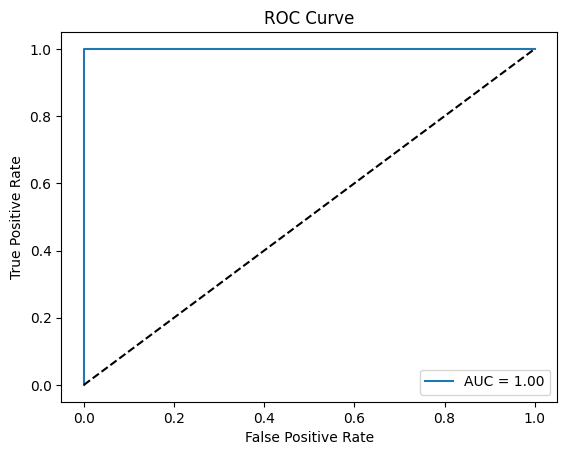

In [2]:
df = df_jo.copy()
# Convertir columnas datetime a timestamps
for col in df.select_dtypes(include=['datetime64']).columns:
    df[col] = df[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

for col in df.select_dtypes(include=['timedelta64']).columns:
    df[col] = df[col].apply(lambda x: x / pd.to_timedelta(1, unit='d') if pd.notnull(x) else None)

df['moderada'] = df['moderated_at'].apply(lambda x: 1 if not pd.isnull(x) else 0)

# Variables predictoras (ajusta según los datos disponibles)
#columnas = ['user_id',    'amount','fee','n_backs','n_fees','n_incidents','to_reimbur', 'type', 'transfer_type','category','charge_moment']
columnas = [ 'stat_cr','stat_fe', 'recovery_status'] # ,'amount'
X = df[columnas].copy()

# Categoricas
#X = pd.get_dummies(X, columns=['type', 'transfer_type', 'category','charge_moment'], drop_first=True, dtype =int)
X = pd.get_dummies(X, columns=['stat_cr', 'stat_fe', 'recovery_status'], drop_first=True)


# Crear el escalador
display(X.head(1))
scaler = StandardScaler()
# Estandarizar todas las columnas
normalizado = scaler.fit_transform(X)
# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
X = pd.DataFrame(normalizado, columns=X.columns, index=df.index)
X.fillna(0, inplace=True)
#X.info()


y = df['needs_m_check_recov'].copy()  #moderada # La columna de la variable objetivo
display(X.head(2))

feature_names = X.columns # Obtener los nombres de las características
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")
clf.fit(X_train, y_train) # Entrena el clasificador
predicciones = clf.predict(X_test) # Realiza predicciones sobre el conjunto de prueba

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Muestra las primeras 10 probabilidades de predicción
print(f"predicciones_probabilidades:\n {predicciones_probabilidades[:10]}\n")

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.4f}")

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()
# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, predicciones_probabilidades[:, 1])
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()